<a href="https://colab.research.google.com/github/anii76/chess-deep-qlearning/blob/main/Deep_Reinforcement_Learning_Chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chess avec Deep Q-Learning
Travail réalisé par :
- Anfal Bourouina

Cette version du Notebook contient 3 façons de jouer avec le modéle:
- Manuellemnt (adversaire humain)
- Un adversaire random
- Stockfish

avec une evaluation stockfish du modéle obtenue.

In [ ]:
#Importing Stockfish
#This installs stockfish in linux machine
!wget https://stockfishchess.org/files/stockfish_14.1_linux_x64_bmi2.zip
!unzip stockfish_14.1_linux_x64_bmi2.zip
!chmod +x stockfish_14.1_linux_x64_bmi2/stockfish_14.1_linux_x64_bmi2
!pip install python-chess==1.2.0

--2022-04-04 19:19:48--  https://stockfishchess.org/files/stockfish_14.1_linux_x64_bmi2.zip
Resolving stockfishchess.org (stockfishchess.org)... 104.25.158.9, 104.25.159.9, 172.67.80.249, ...
Connecting to stockfishchess.org (stockfishchess.org)|104.25.158.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28784829 (27M) [application/zip]
Saving to: ‘stockfish_14.1_linux_x64_bmi2.zip’

stockfish_14.1_linu 100%[===================>]  27.45M  12.2MB/s    in 2.3s    

2022-04-04 19:19:51 (12.2 MB/s) - ‘stockfish_14.1_linux_x64_bmi2.zip’ saved [28784829/28784829]

Archive:  stockfish_14.1_linux_x64_bmi2.zip
  inflating: stockfish_14.1_linux_x64_bmi2/AUTHORS  
  inflating: stockfish_14.1_linux_x64_bmi2/Copying.txt  
  inflating: stockfish_14.1_linux_x64_bmi2/info.txt  
  inflating: stockfish_14.1_linux_x64_bmi2/stockfish_14.1_linux_x64_bmi2  
   creating: stockfish_14.1_linux_x64_bmi2/stockfish_14.1_src/
   creating: stockfish_14.1_linux_x64_bmi2/stockfish_14.1_src/

In [ ]:
import numpy as np
import random
import chess
import chess.engine
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,Flatten,Reshape
from keras.layers.convolutional import Conv2D
from IPython.display import clear_output

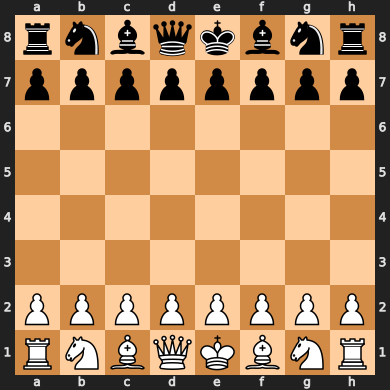

In [ ]:
chess.Board() # board initial 

##Paramétres de l'entrainement

In [ ]:
# Configuration paramaters for the epsilon-greedy algorithm
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 100
num_actions = 4096

In [ ]:
#variables settings

# Instantiate a keras optimizer.
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
running_reward = 0
episode_count = 0
frame_count = 0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 100
# Using huber loss for stability
loss_function = keras.losses.Huber() 
len_episodes = 0
iterations = 150

## Représentation des coups 
On represente les coups par des valeurs numériques qu'on puisse utiliser dans le réseau de neurons. Le vecteur `move2num` mappe les coups à des valeurs numériques, alors que le vecteur `num2move` mappe les valeurs numériques au coups correspondants. Par exemple : 
- le coup `a1b1` correspond au numéro 1.
- le coup `g2g3` correspond au numéro 918.
- et le coup `h8h8` correspond au numéro 4095.

In [ ]:
#Chess part (board_conversion)
#filtrer les coups legaux 
def filter_legal_moves(board,logits):
    filter_mask = np.zeros(logits.shape)
    legal_moves = board.legal_moves
    for legal_move in legal_moves:
        from_square = legal_move.from_square
        to_square = legal_move.to_square
        idx = move2num[chess.Move(from_square,to_square)]
        filter_mask[idx] = 1
    new_logits = logits*filter_mask
    return new_logits

num2move = {}
move2num = {}
counter = 0
#les mouvement executer 
for from_sq in range(64):
    for to_sq in range(64):
        num2move[counter] = chess.Move(from_sq,to_sq)
        move2num[chess.Move(from_sq,to_sq)] = counter
        counter += 1  

## Représenatation de l'échequier
Convertir la représentation `pgn` de l'echequier a un vecteur 8x8x12 pour le l'input du réseau de neurones (CNN).


In [ ]:
def translate_board(board): 
    pgn = board.epd()
    foo = []  
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []  
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append(chess_dict['.'])
            else:
                foo2.append(chess_dict[thing])
        foo.append(foo2)
    return np.array(foo)

#Uppercase => White
#Lowercase => Black
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}

## Définition de l'environement
l'environnement garde les informations relatifs à l'état de jeu , la configuration de l'échequier `board` et `translate_board`, l'historiques des coups réalisés `action_history`, l'historique des récompenses `reward_history` et des parties terminées `done_history`. 
* La fonction `reset` sert à reinitialiser les paramétres ci-dessus en cas de dépassement de mémoire.
* La fonction step mis à jour les paramétres précedents avec chaque action réalisée, on apporte un reward = 100 pour un checkmate , 0 sinon.
* La fonction `update_q_values` mis à jour la table Q des valeur (évaluations du couple {état, action}) selon la formule : 
${Q}(s,a) = r(s,a) + γ {Q}_m(s',a) $ 



In [ ]:
#Environement
class ChessEnv():
    def __init__(self):
        self.board = chess.Board()
        self.action_history = []
        self.state_history = []
        self.state_next_history = []
        self.rewards_history = []
        self.done_history = []
        self.episode_reward_history = []
        pass

#1. Return State
#This function simply returns a vector that fully expresses the 
#information accessible to the agent environment, that can be 
#plugged into the neural network        
    def translate_board(self):
        return translate_board(self.board)
    def reset(self):
        self.board = chess.Board()
        if len(self.rewards_history) > max_memory_length:
            del self.rewards_history[:1]
            del self.state_history[:1]
            del self.state_next_history[:1]
            del self.action_history[:1]
            del self.done_history[:1]
        return translate_board(self.board)
    
#2. Accept Action
#This function accepts an action and changes the state of the 
#environment by this action.    
    def step(self,action):
        reward = 0
        done = False
        
        state = self.translate_board()
        self.board.push(action)
        state_next = self.board
        state_next = translate_board(state_next)
        
        if self.board.is_checkmate():
            reward = 100
        if self.board.is_game_over():
            done = True
    
        self.action_history.append(move2num[action])
        self.state_history.append(state)
        self.state_next_history.append(state_next)
        self.done_history.append(done)
        self.rewards_history.append(reward)
        return state_next,reward,done

#3.update q_value  le callcule du cout et l'insere dans la table ds q value 
    def update_q_values(self):
        indices = np.random.choice(range(len(self.done_history)), size=batch_size)
            
        state_sample = np.array([self.state_history[i] for i in indices])
        state_next_sample = np.array([self.state_next_history[i] for i in indices])
        rewards_sample = [self.rewards_history[i] for i in indices]
        action_sample = [self.action_history[i] for i in indices]
        done_sample = tf.convert_to_tensor(
            [float(self.done_history[i]) for i in indices]
        )
        
        future_rewards = model_target.model.predict(state_next_sample)
        
        updated_q_values = rewards_sample + gamma * tf.reduce_max(
            future_rewards, axis=1
        )

        updated_q_values = updated_q_values * (1 - done_sample) - done_sample

        masks = tf.one_hot(action_sample, num_actions)
        return state_sample,masks,updated_q_values
    
env = ChessEnv()

## Définition du modéle
On utilise un réseau de neurons de 3 couches de convolutions corresponds a un vecteur 8x8x12 representant l'échequier.
La fonction `predict` convertit l'echequier à un tensor (neuron), calcule les probabilités pour chaque action puis choisit l'action qui a la plus grande proba parmi les actions permises `legal_moves`. La fonction `explore` affect des poids random au actions (moves) puis choisi celles avec la plus grande valeurs parmis les coups possibles.

In [ ]:
class Q_model():
    def __init__(self):
        self.model = self.create_q_model()

    def create_q_model(self):
     #l'axe de l'echantillon :8par 8 avec 12 piece distincte 
        input_layer = keras.Input(shape=(8, 8, 12)) 
       

        # Convolutions on the frames on the screen 
        x = Conv2D(filters=64,padding="same",kernel_size = 2,strides = (2,2))(input_layer)
        x = Conv2D(filters=128,padding="same",kernel_size=2,strides = (2,2))(x)
        x = Conv2D(filters=256,padding="same",kernel_size=2,strides = (2,2))(x)
        x = Flatten()(x)

        action = Dense(4096,activation = 'softmax')(x)
        return keras.Model(inputs=input_layer, outputs=action)
    
    #prédire et renvoie l'action à exécuter based on previous experience
    def predict(self,env):
        state_tensor = tf.convert_to_tensor(env.translate_board())
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = self.model(state_tensor, training=False)
        action_space = filter_legal_moves(env.board,action_probs[0])
        action = np.argmax(action_space, axis=None)
        move= num2move[action]
        return move,action
    
    #explore action space and choose the action avec le n° le plus grand  
    def explore(self,env):
        action_space = np.random.randn(4096)
        action_space = filter_legal_moves(env.board,action_space)
        action = np.argmax(action_space, axis=None)
        move= num2move[action]
        return move,action
        
    
model = Q_model()
model_target = Q_model()

In [ ]:
#Architecture du Modéle
model.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 8, 12)]        0         
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 64)          3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         32896     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 256)         131328    
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
Total params: 1,220,032
Trainable params: 1,220,032
Non-train

## Entrainement du modéle


In [ ]:
# Training 

# epochs
iterations = 100
for _ in range(iterations):
    
    state = np.array(env.reset())
    episode_reward = 0
    len_episodes += 1

    
    #iterate over one episode (game)
    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        #Choix entre exploration ou exploitation suivant les valeur de epsilon
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            move,action = model.explore(env)
        else:
            move,action = model.predict(env)

        #grredy et changement de valeur d'epsilon     
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)
        
        #record the reward, the future state and if the environment episode is over
        state_next, reward, done = env.step(move)

        episode_reward += reward

        # Iterate over the batches of a dataset.
        # if frame_count is modulo 4 and explored actions are over a batch size (means a batch is ready to be used in training)   
        if frame_count % update_after_actions == 0 and len(env.done_history) > batch_size:
            
            state_sample,masks,updated_q_values = env.update_q_values()
            
            with tf.GradientTape() as tape:
                q_values = model.model(state_sample)
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Loss value for this batch
                loss = loss_function(updated_q_values, q_action)

            # Get gradients of loss wrt the weights.
            grads = tape.gradient(loss, model.model.trainable_variables)
            # Update the weights of the model.
            optimizer.apply_gradients(zip(grads, model.model.trainable_variables))
        
        # at each 100 batches update target model
        if frame_count % update_target_network == 0:
            model_target.model.set_weights(model.model.get_weights())
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))
            
        env.episode_reward_history.append(episode_reward)
        if done:
            break
    episode_count += 1    

running reward: 0.00 at episode 1, frame count 100
running reward: 0.00 at episode 2, frame count 200
running reward: 0.00 at episode 3, frame count 300
running reward: 0.00 at episode 4, frame count 400
running reward: 0.00 at episode 5, frame count 500
running reward: 0.00 at episode 6, frame count 600
running reward: 0.00 at episode 7, frame count 700
running reward: 0.00 at episode 8, frame count 800
running reward: 0.00 at episode 9, frame count 900
running reward: 0.00 at episode 10, frame count 1000
running reward: 0.00 at episode 11, frame count 1100
running reward: 0.00 at episode 12, frame count 1200
running reward: 0.00 at episode 13, frame count 1300
running reward: 0.00 at episode 14, frame count 1400
running reward: 0.00 at episode 15, frame count 1500
running reward: 0.00 at episode 16, frame count 1600
running reward: 0.00 at episode 17, frame count 1700
running reward: 0.00 at episode 18, frame count 1800
running reward: 0.00 at episode 19, frame count 1900
running rew

In [ ]:
#Les Q-valeurs obtenues aprés l'entrainement
np.array(memoryview(q_values))

array([[0.00023281, 0.00024332, 0.00023786, ..., 0.0002327 , 0.00024332,
        0.00023729],
       [0.00025085, 0.00024496, 0.00024612, ..., 0.00024367, 0.00023358,
        0.00024922],
       [0.00024007, 0.00024485, 0.00024381, ..., 0.00023297, 0.00024652,
        0.00025532],
       ...,
       [0.00024228, 0.0002464 , 0.00023902, ..., 0.00023573, 0.00024759,
        0.00024155],
       [0.00023914, 0.00024808, 0.00023878, ..., 0.00023587, 0.00024418,
        0.00024955],
       [0.00022855, 0.00024628, 0.00023663, ..., 0.00024671, 0.00024947,
        0.00024411]], dtype=float32)

## Evaluation du modéle
1. La fonction `stockfish` , étant donné une configuration et une profondeur , retourne le score de cette partie.
2. La fonction `play_random` où l'agent joue avec un advarsaire qui génère des coups aléatoires.
3. La fonction `play_adver` où l'agent joue avec un adversaire humain ( on joue avec le modéle).
4. La fonction `play_stockfish` où l'agent joue avec stockfish et génére l'evaluation des moves et configuration.

In [ ]:
#stockfish score function
def stockfish(board, depth):
  with chess.engine.SimpleEngine.popen_uci("stockfish_14.1_linux_x64_bmi2/stockfish_14.1_linux_x64_bmi2") as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].black().score()
    return score

In [ ]:
#Garder trace des moves de chaque joueurs
#Adversary moves (white)
adv_moves = []
  
#Model Moves (black)
model_moves = []

game_over at it :  220


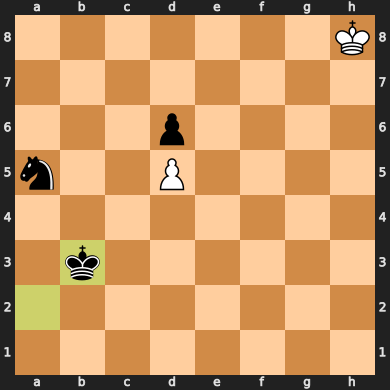

In [ ]:
def play_random():
  
  #initilize board
  env.board = chess.Board()
  
  #episode_steps
  i = 0
  
  while True:
    i += 1
    all_moves = list(env.board.legal_moves)
    #print(f'\n{env.board}')
    
    #random adversaire 
    adv_move = random.choice(all_moves) ; adv_moves.append(adv_move)
    env.board.push(adv_move) 
    model_move,action = model.predict(env) ; model_moves.append(model_move)
    env.board.push(model_move)
    
    if env.board.is_game_over():
      print("game_over at it : ",i)
      break
  return i

depth = play_random()
env.board

In [ ]:
adv_moves[0] , model_moves[0] , depth

(Move.from_uci('a2a4'), Move.from_uci('b7b5'), 220)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R

Enter move : g2g4
r n b q k b n r
p p p . p p p p
. . . p . . . .
. . . . . . . .
. . . . . . P .
. . . . . . . .
P P P P P P . P
R N B Q K B N R

Enter move : g4g5
r n b q k b n r
p p p . p . p p
. . . p . p . .
. . . . . . P .
. . . . . . . .
. . . . . . . .
P P P P P P . P
R N B Q K B N R

Enter move : g5f6
r n b q k b n r
p p p . p . . p
. . . p . p . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P . P
R N B Q K B N R

Enter move : g1f3
r n b q k b n r
p p . . p . . p
. . . p . p . .
. . p . . . . .
. . . . . . . .
. . . . . N . .
P P P P P P . P
R N B Q K B . R

Enter move : h2h3
r n b . k b n r
p p q . p . . p
. . . p . p . .
. . p . . . . .
. . . . . . . .
. . . . . N . P
P P P P P P . .
R N B Q K B . R

Enter move : h3h4
r n b . . b n r
p p q k p . . p
. . . p . p . .
. . p . . . . .
. . . . . . . P
. . . . . N . .
P P P P P P . .
R N B 

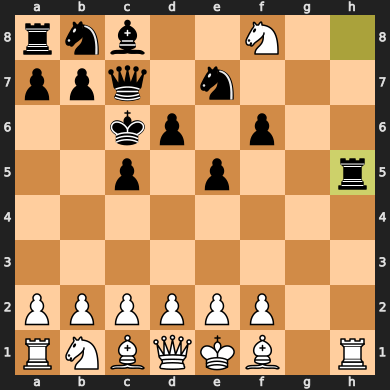

In [ ]:
def play_adver(depth):
  
  #initilize board
  env.board = chess.Board()
  
  for i in range(depth):
    all_moves = list(env.board.legal_moves)
    print(env.board)
    
    #TODO: add rook and pion transformation
    user_move = input("\nEnter move : ")
    adv_move = chess.Move.from_uci(user_move)
    while not (adv_move in all_moves) :
      user_move = input("\nEnter a valid move : ")
      adv_move = chess.Move.from_uci(user_move)
    
    env.board.push(adv_move)
    model_move,action = model.predict(env) ; model_moves.append(model_move)
    env.board.push(model_move)
      
    if env.board.is_game_over():
      print("game_over at it :"+i)
      break

depth = 10 #random.randrange(0, 200)
play_adver(depth)
env.board

In [ ]:
#evaluer la partie précédente
print(stockfish(env.board, depth))

-74


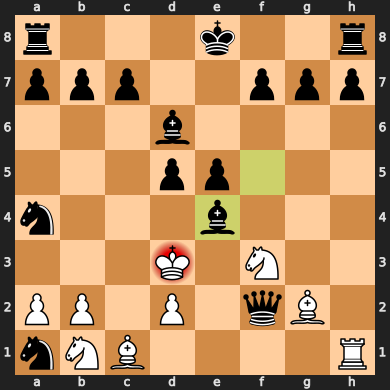

In [ ]:
#Play against stockfish
score_model = []
score_stockfish = []

def play_stockfish():
  env.board = chess.Board()
  
  with chess.engine.SimpleEngine.popen_uci("stockfish_14.1_linux_x64_bmi2/stockfish_14.1_linux_x64_bmi2") as engine:
    while True:
      move,action = model.predict(env)
      env.board.push(move)
      #print(f'\n{env.board}')
      if env.board.is_game_over():
        break
      
      move = engine.analyse(env.board, chess.engine.Limit(time=1), info=chess.engine.INFO_PV)['pv'][0]
      result = engine.analyse(env.board, chess.engine.Limit(depth=1))
      score_model.append(result['score'].white().score())
      score_stockfish.append(result['score'].black().score())
      env.board.push(move)
      #print(f'\n{env.board}')
      if env.board.is_game_over():
        break

play_stockfish()
env.board

In [ ]:
score_model , score_stockfish

([-15,
  -26,
  -141,
  -279,
  -367,
  -653,
  -1307,
  -1492,
  -1992,
  -2007,
  -3238,
  None,
  None,
  None,
  None,
  None],
 [15,
  26,
  141,
  279,
  367,
  653,
  1307,
  1492,
  1992,
  2007,
  3238,
  None,
  None,
  None,
  None,
  None])

In [ ]:
#graph